In [ ]:
#default_exp data.block

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.transform import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc

In [ ]:
#For examples, so not exported
from local.vision.core import *
from local.vision.augment import *

# Data block

> High level API to quickly get your data in a `DataBunch`

## General API

In [ ]:
from inspect import isfunction,ismethod

In [ ]:
def merge_tfms(*tfms):
    "Group the `tfms` in a single list, removing duplicates (from the same class) and instantiating"
    res,types = [],[]
    for ts in tfms:
        for t in L(ts):
            cls = t if isinstance(t, type) else t.__qualname__ if (isfunction(t) or ismethod(t)) else t.__class__
            if cls not in types or not isinstance(t, type):
                res = [f for f,t_ in zip(res,types) if t_ != cls]
                types = [t_ for t_ in types if t_ != cls]
                res.append(t() if isinstance(t, type) else t)
                types.append(cls)
    return res

In [ ]:
tfms = merge_tfms([Categorize, MultiCategorize, Categorize(['dog', 'cat'])])
#Categorize is there twice, the generic version is removed and the instantiated one is kept.
test_eq(len(tfms), 2)
test_eq(tfms[0].__class__, MultiCategorize)
test_eq(tfms[1].__class__, Categorize)
test_eq(tfms[1].vocab, ['dog', 'cat'])

tfms = merge_tfms(Categorize(['dog', 'cat']), [Categorize, MultiCategorize])
#Same in the other direction.
test_eq(len(tfms), 2)
test_eq(tfms[1].__class__, MultiCategorize)
test_eq(tfms[0].__class__, Categorize)
test_eq(tfms[0].vocab, ['dog', 'cat'])

tfms = merge_tfms([Categorize, MultiCategorize, Categorize(['dog', 'cat'])], Categorize(['a', 'b']))
#If there are several instantiated versions, the last one is kept.
test_eq(len(tfms), 2)
test_eq(tfms[0].__class__, MultiCategorize)
test_eq(tfms[1].__class__, Categorize)
test_eq(tfms[1].vocab, ['a', 'b'])

tfms = merge_tfms([PILImage.create, PILImage.show])
#Check methods are properly separated
test_eq(len(tfms), 2)
tfms = merge_tfms([show_image, set_trace])
#Check functions are properly separated
test_eq(len(tfms), 2)

In [ ]:
#export
@docs
class DataBlock():
    "Generic container to quickly build `DataSource` and `DataBunch`"
    default_dl_tfms = Cuda
    def __init__(self, types=None, get_items=None, splitter=None, labeller=None):
        if types is not None:     self.types = types
        if get_items is not None: self.get_items = get_items 
        if splitter is not None:  self.splitter = splitter
        if labeller is not None:  self.labeller = labeller
            
    def get_items(self, source): pass
    def splitter(self, items): pass
    def labeller(self, item): pass
    
    def _def_tfm(self, t):
        r = L(t.create if hasattr(t, 'create') else None)
        return r + L(getattr(t, 'default_type_tfms', None))
        
    # TODO: method to replace defaults
    def datasource(self, source, type_tfms=None, ds_tfms=None):
        items = self.get_items(source)
        splits = self.splitter(items)
        if type_tfms is None: type_tfms = [L() for t in self.types]
        type_tfms = L(merge_tfms(self._def_tfm(t), tfm) for (t,tfm) in zip(self.types, type_tfms))
        type_tfms = type_tfms[0] + L(self.labeller + L(tfm) for tfm in type_tfms[1:])
        ds_tfms = L(merge_tfms(*[getattr(t, 'default_ds_tfms', L()) for t in self.types], ds_tfms))
        return DataSource(items, type_tfms=type_tfms, ds_tfms=ds_tfms, filts=splits)
    
    def databunch(self, source, type_tfms=None, ds_tfms=None, dl_tfms=None, bs=16, **kwargs):
        dsrc = self.datasource(source, type_tfms=type_tfms, ds_tfms=ds_tfms)
        dl_tfms = L(merge_tfms(*[getattr(t, 'default_dl_tfms', L()) for t in self+L(self.types)], dl_tfms))
        return dsrc.databunch(tfms=dl_tfms, bs=bs, **kwargs)
    
    _docs = dict(get_items="Pass at init or implement how to get your raw items from a `source`",
                 splitter="Pass at init or implement how to split your `items`",
                 labeller="Pass at init or implement how to label a raw `item`",
                 datasource="Create a `Datasource` from `source` with `tfms` and `tuple_tfms`",
                 databunch="Create a `DataBunch` from `source` with `tfms`")

### Building a `DataBlock`

To build a `DataBlock` you need to give the lbirary four things: the types of your input/labels then three function.

In [ ]:
show_doc(DataBlock.get_items)

<h4 id="<code>DataBlock.get_items</code>" class="doc_header"><code>DataBlock.get_items</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/10_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.get_items</code>(**`source`**)

Pass at init or implement how to get your raw items from a `source`

In [ ]:
show_doc(DataBlock.splitter)

<h4 id="<code>DataBlock.splitter</code>" class="doc_header"><code>DataBlock.splitter</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/10_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.splitter</code>(**`items`**)

Pass at init or implement how to split your `items`

In [ ]:
show_doc(DataBlock.labeller)

<h4 id="<code>DataBlock.labeller</code>" class="doc_header"><code>DataBlock.labeller</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/10_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.labeller</code>(**`item`**)

Pass at init or implement how to label a raw `item`

### Using a `DataBlock`

Once those informations are all provided, you automatically get a `DataSource` or a `DataBunch`:

In [ ]:
show_doc(DataBlock.datasource)

<h4 id="<code>DataBlock.datasource</code>" class="doc_header"><code>DataBlock.datasource</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/10_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.datasource</code>(**`source`**, **`type_tfms`**=*`None`*, **`ds_tfms`**=*`None`*)

Create a `Datasource` from `source` with `tfms` and `tuple_tfms`

In [ ]:
show_doc(DataBlock.databunch)

<h4 id="<code>DataBlock.databunch</code>" class="doc_header"><code>DataBlock.databunch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/10_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.databunch</code>(**`source`**, **`type_tfms`**=*`None`*, **`ds_tfms`**=*`None`*, **`dl_tfms`**=*`None`*, **`bs`**=*`16`*, **\*\*`kwargs`**)

Create a [`DataBunch`](/data.core.html#DataBunch) from `source` with `tfms`

## Examples

### Classification

In [ ]:
from local.vision.core import *
from local.vision.augment import *

In [ ]:
PILImage.default_ds_tfms = ImageToByteTensor
PILImage.default_dl_tfms = ByteToFloatTensor

In [ ]:
class MNIST(DataBlock):
    types = (PILImage, Category)
    def get_items(self, source): return get_image_files(Path(source))
    def splitter(self, items): return GrandparentSplitter()(items)
    
    @staticmethod
    def labeller(item): return parent_label(item)

In [ ]:
mnist = MNIST().datasource(untar_data(URLs.MNIST_TINY))
#TODO: access vocab
# mnist = MNIST().datasource(untar_data(URLs.MNIST_TINY), type_tfms=[None, Categorize(['1', '2', '3', '4'])])
#test_eq(mnist.vocab, ['1', '2', '3', '4'])

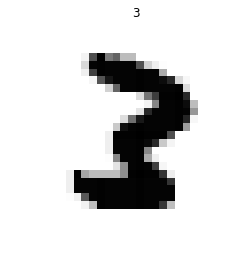

In [ ]:
mnist = MNIST().datasource(untar_data(URLs.MNIST_TINY))
mnist.train.show_at(0, cmap='Greys');

In [ ]:
mnist = DataBlock(types=(PILImage, Category), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  labeller=parent_label)

In [ ]:
dbunch = mnist.databunch(untar_data(URLs.MNIST_TINY))

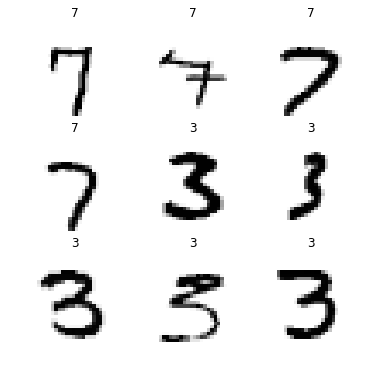

In [ ]:
_,axs = plt.subplots(3,3,figsize=(6,6))
dbunch.show_batch(ctxs = axs.flatten(), cmap='Greys')

In [ ]:
pets = DataBlock(types=(PILImage, Category), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 labeller=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

In [ ]:
dbunch = pets.databunch(untar_data(URLs.PETS)/"images", ds_tfms=Resize(128),
                        dl_tfms=aug_transforms())

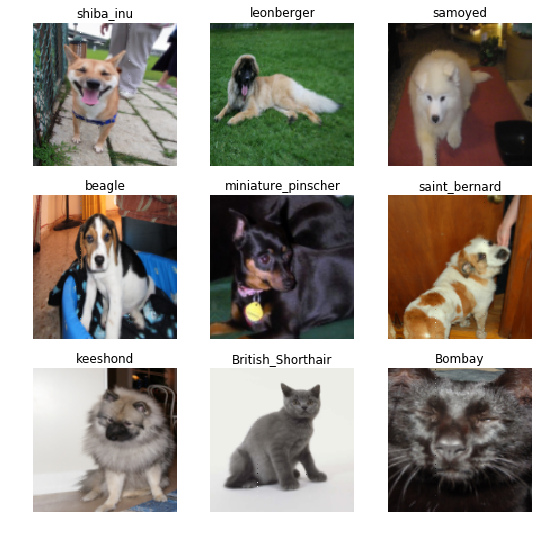

In [ ]:
_,axs = plt.subplots(3,3,figsize=(9,9))
dbunch.show_batch(ctxs = axs.flatten())

### Multi-label classification

In [ ]:
MultiCategory.default_type_tfms = OneHotEncode

In [ ]:
planet_source = untar_data(URLs.PLANET_TINY)

In [ ]:
df = pd.read_csv(planet_source/"labels.csv")
im_names = df['image_name'].values
tags = df['tags'].values

In [ ]:
name2tags = {n:t for n,t in zip(im_names, tags)}

In [ ]:
def label_func(fn)->None:
    trunc_name = str(fn).split(os.path.sep)[-1].split('.')[0]
    return name2tags[trunc_name].split(' ')

In [ ]:
planet = DataBlock(types=(PILImage, MultiCategory),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   labeller=label_func)

In [ ]:
PILImage._open_args = {'mode': 'RGB'}

In [ ]:
dbunch = planet.databunch(planet_source/"train",                            
                          dl_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

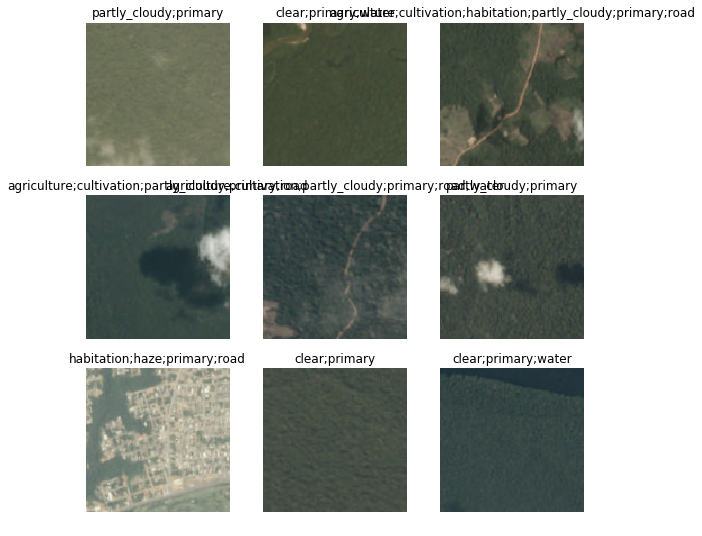

In [ ]:
_,axs = plt.subplots(3,3,figsize=(9,9))
dbunch.show_batch(ctxs = axs.flatten())

### Segmentation

In [ ]:
camvid = DataBlock(types=(PILImage, PILMask),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   labeller=lambda o: untar_data(URLs.CAMVID_TINY)/'labels'/f'{o.stem}_P{o.suffix}')

In [ ]:
dbunch = camvid.databunch(untar_data(URLs.CAMVID_TINY)/"images", dl_tfms=aug_transforms())

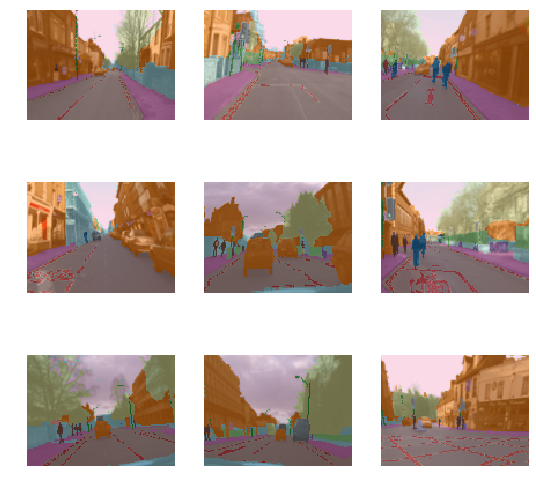

In [ ]:
_,axs = plt.subplots(3,3,figsize=(9,9))
dbunch.show_batch(ctxs = axs.flatten(), vmin=1, vmax=30)

### Points

In [ ]:
TensorPoint.default_ds_tfms = PointScaler

In [ ]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = pickle.load(open(biwi_source/'centers.pkl', 'rb'))

biwi = DataBlock(types=(PILImage, TensorPoint),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 labeller=lambda o:fn2ctr[o.name].flip(0))

In [ ]:
dbunch = biwi.databunch(biwi_source, dl_tfms=aug_transforms())

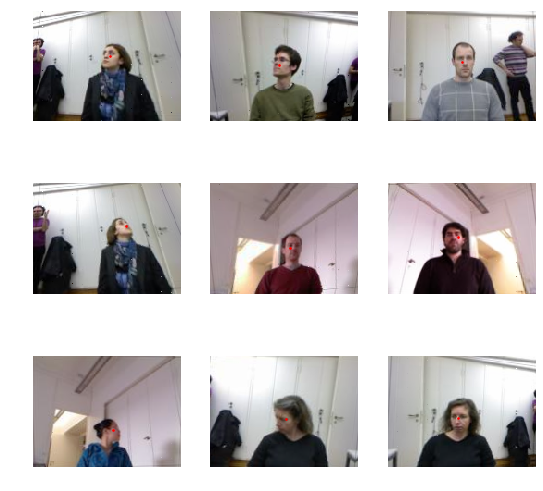

In [ ]:
_,axs = plt.subplots(3,3,figsize=(9,9))
dbunch.show_batch(ctxs = axs.flatten())

### Bounding boxes

In [ ]:
BBox.default_type_tfms = BBoxCategorize
BBox.default_ds_tfms = BBoxScaler

In [ ]:
def bb_pad_collate(samples, pad_idx=0):
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    if isinstance(samples[0][1], int): return data_collate(samples)
    max_len = max([len(s[1][1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples):
        imgs.append(s[0][None])
        bbs, lbls = s[1]
        if not (bbs.nelement() == 0):
            bboxes[i,-len(lbls):] = bbs
            labels[i,-len(lbls):] = tensor(lbls)
    return torch.cat(imgs,0), (bboxes,labels)

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

coco = DataBlock(types=(PILImage, BBox),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 labeller=lambda o: img2bbox[o.name])

In [ ]:
dbunch = coco.databunch(coco_source, ds_tfms=Resize(128), dl_tfms=aug_transforms(), 
                        collate_fn=bb_pad_collate)

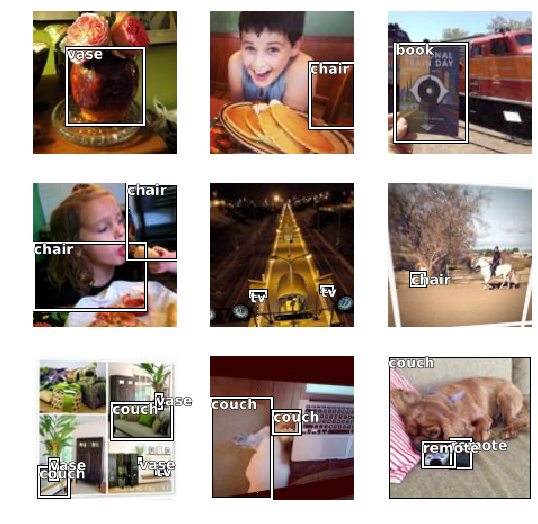

In [ ]:
_,axs = plt.subplots(3,3,figsize=(9,9))
dbunch.show_batch(ctxs = axs.flatten())